In [1]:
%matplotlib inline
# %load ../../utility/initialization.py
'''
How to Train Your Dragon: V4
Sequentially initialize FT reactive distillation model automatically
'''
# system imports
import sys
import os
import datetime
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../..'))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# import pickle
import dill
from copy import deepcopy

# pyomo imports
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule
from stages.condenser_stage import condenser_stage_rule
from stages.reboiler_stage import reboiler_stage_rule

from utility.display_utility import beautify, beautify_reactive, HiddenLogs, HiddenPrints, \
                                    plot_distribution, plot_product_distribution, check_product_spec
from utility.model_utility import add_dual, update_dual, delete_dual, check_DOF, check_iteration, tray_translator
from utility.model_utility import which_MPCC, select_MPCC, augmented_objective, add_solver
from utility.time_utility import create_filename_time, log_now, log_end

2018-08-05 00:37:54 - Start Program


In [2]:
logname = create_filename_time()
log_text_dir = './log/text/opt_'+logname+'.dat'
log_figure_dir = './log/figure/opt_'+logname+'.pdf'
os.makedirs('./log/text',exist_ok=True)
os.makedirs('./log/figure',exist_ok=True)
os.makedirs('./log/model',exist_ok=True)

In [3]:
with open('./log/model/stage_20_pf.pickle','rb') as f:
    model = dill.load(f)

In [4]:
for j in model.reactive:
    select_MPCC(model.reactive[j],'NCP')
select_MPCC(model.reboiler,'NCP')

> Selected MPCC: reactive[1].MPCC_P_NCP
s_L:  1.964812775101591e-08
s_V:  0.0

> Selected MPCC: reactive[2].MPCC_P_NCP
s_L:  2.282828746889007e-08
s_V:  0.0

> Selected MPCC: reactive[3].MPCC_P_NCP
s_L:  2.541409097349865e-08
s_V:  0.0

> Selected MPCC: reactive[4].MPCC_P_NCP
s_L:  2.8964348141935536e-08
s_V:  0.0

> Selected MPCC: reactive[5].MPCC_P_NCP
s_L:  3.6801820770708585e-08
s_V:  0.0

> Selected MPCC: reactive[6].MPCC_P_NCP
s_L:  5.067497122028571e-08
s_V:  0.0

> Selected MPCC: reactive[7].MPCC_P_NCP
s_L:  8.886416478990899e-08
s_V:  0.0

> Selected MPCC: reactive[8].MPCC_P_NCP
s_L:  2.636894172205893e-07
s_V:  0.0

> Selected MPCC: reactive[9].MPCC_P_NCP
s_L:  2.915820537690447e-07
s_V:  0.0

> Selected MPCC: reactive[10].MPCC_P_NCP
s_L:  2.557694373298898e-07
s_V:  0.0

> Selected MPCC: reactive[11].MPCC_P_NCP
s_L:  2.931749515530684e-07
s_V:  0.0

> Selected MPCC: reactive[12].MPCC_P_NCP
s_L:  2.215560288433305e-07
s_V:  0.0

> Selected MPCC: reactive[13].MPCC_P_NCP
s_L:  

# Add tray optimization related sets and variables

In [5]:
model.sigma = pe.Param(initialize=0.5,mutable=True)
model.epi = pe.Param(initialize=1e-5,mutable=True)
model.scale_epi = pe.Param(initialize=1e-5,mutable=True)

In [6]:
model.P_tray = pe.Var(model.TRAY_total,m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.N_tray = pe.Var(m.PRODUCT,within=pe.NonNegativeReals) # extended range from condenser (0) to reboiler (N+1)
model.P_total = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.P_total_dry = pe.Var(m.PRODUCT,within=pe.NonNegativeReals,initialize=0)
model.x_P = pe.Var(m.COMP_TOTAL,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))
model.x_P_dry = pe.Var(m.COMP_ORG,m.PRODUCT,within=pe.NonNegativeReals,bounds=(0,1))

# Add equations

In [7]:
for i,j in model.P_tray:
    if j != 'naphtha' and j != 'heavy':
        model.P_tray[i,j].setlb(model.epi)

for j in model.P_total:
    if j != 'naphtha' and j != 'heavy':
        model.P_total[j].setlb(model.epi*len(model.TRAY_total))
    else:
        continue
        model.P_total[j].setlb(model.epi)

In [8]:
# sum of liquid draw for all products for each stage
def stage_sum_product_rule(model,j):
    return tray_translator(model,j).L['P'] == sum(model.P_tray[j,p] for p in m.PRODUCT)
model.stage_sum_product_con = pe.Constraint(model.TRAY_total,rule=stage_sum_product_rule)

# liquid product mass balance
def product_sum_stage_rule(model,j,p):
    if p == 'naphtha' or p == 'heavy':
        return pe.Constraint.Skip
    return model.P_tray[j,p] == model.epi + (model.P_total[p] - model.epi*len(model.TRAY_total)) * pe.exp(-(model.TRAY_total.ord(j)-1-model.N_tray[p])**2/model.sigma) / \
            sum(pe.exp(-(model.TRAY_total.ord(j_)-1-model.N_tray[p])**2/model.sigma) for j_ in model.TRAY_total)
model.product_sum_stage_con = pe.Constraint(model.TRAY_total,m.PRODUCT,rule=product_sum_stage_rule)

# condenser and reboiler
model.product_sum_stage_con2 = pe.ConstraintList()
model.product_sum_stage_con2.add(expr = model.P_tray['condenser','naphtha'] == model.P_total['naphtha'])
model.product_sum_stage_con2.add(expr = model.P_tray['reboiler','heavy'] == model.P_total['heavy'])

# liquid product component mass balance
def mass_balance_product_rule(model,i,p):
#     return pe.log(model.scale_epi+sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total)) == \
#             pe.log(model.scale_epi+(model.P_total[p])*model.x_P[i,p])
    return sum(model.P_tray[j,p]*tray_translator(model,j).x[i] for j in model.TRAY_total) == (model.P_total[p])*model.x_P[i,p]
model.mass_balance_product_con = pe.Constraint(m.COMP_TOTAL,m.PRODUCT,rule=mass_balance_product_rule)

In [9]:
# dry liquid product component 
def product_sum_dry_rule(model,p):
    return model.P_total_dry[p] == model.P_total[p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))
model.product_sum_dry_con = pe.Constraint(m.PRODUCT,rule=product_sum_dry_rule)

# dry liquid product component mass balance
def mass_balance_dry_rule(model,i,p):
#     return pe.log(model.scale_epi+model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG))) == \
#             pe.log(model.scale_epi+model.x_P[i,p])
    return model.x_P_dry[i,p] * (1 - sum(model.x_P[i,p] for i in m.COMP_INORG)) == model.x_P[i,p]
model.mass_balance_dry_con = pe.Constraint(m.COMP_ORG,m.PRODUCT,rule=mass_balance_dry_rule)

# Transfer from original liquid side-draw variable to product variable

### Transfer fixed side-draw variables

In [10]:
for j in model.reactive:
    model.reactive[j].PR_L.unfix()

for j in model.TRAY_total:
    model.P_tray[j,'naphtha'].fix(0)
    model.P_tray[j,'heavy'].fix(0)
    
model.P_tray['condenser','naphtha'].unfix(); # model.P_tray['condenser','naphtha'].setlb(model.epi)
model.P_tray['condenser','naphtha'].set_value(model.condenser.L['P'].value)
model.P_tray['4','intermediate'].set_value(model.reactive[4].L['P'].value)
model.P_tray['7','gasoline'].set_value(model.reactive[7].L['P'].value)
model.P_tray['10','diesel'].set_value(model.reactive[10].L['P'].value)
model.P_tray['reboiler','heavy'].unfix(); # model.P_tray['reboiler','heavy'].setlb(model.epi)
model.P_tray['reboiler','heavy'].set_value(model.reboiler.L['P'].value)

model.N_tray['naphtha'].fix(0)
model.N_tray['intermediate'].fix(4)
model.N_tray['gasoline'].fix(7)
model.N_tray['diesel'].fix(10)
model.N_tray['heavy'].fix(21)

### Initialized newly created value

In [11]:
model.P_total['naphtha'].set_value(model.P_tray['condenser','naphtha'].value)
model.P_total['intermediate'].fix(model.P_tray['4','intermediate'].value)
model.P_total['gasoline'].fix(model.P_tray['7','gasoline'].value)
model.P_total['diesel'].fix(model.P_tray['10','diesel'].value)
model.P_total['heavy'].set_value(model.P_tray['reboiler','heavy'].value)

for i in m.COMP_TOTAL:
    model.x_P[i,'naphtha'].set_value(model.condenser.x[i].value)
    model.x_P[i,'intermediate'].set_value(model.reactive[4].x[i].value)
    model.x_P[i,'gasoline'].set_value(model.reactive[7].x[i].value)
    model.x_P[i,'diesel'].set_value(model.reactive[10].x[i].value)
    model.x_P[i,'heavy'].set_value(model.reboiler.x[i].value)

In [12]:
model.P_total_dry['naphtha'].set_value(model.P_tray['condenser','naphtha'].value * (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
model.P_total_dry['intermediate'].set_value(model.P_tray['4','intermediate'].value * (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['gasoline'].set_value(model.P_tray['7','gasoline'].value * (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['diesel'].set_value(model.P_tray['10','diesel'].value * (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
model.P_total_dry['heavy'].set_value(model.P_tray['reboiler','heavy'].value * (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

for i in m.COMP_ORG:
    model.x_P_dry[i,'naphtha'].set_value(model.condenser.x[i].value / (1 - sum(model.condenser.x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'intermediate'].set_value(model.reactive[4].x[i].value / (1 - sum(model.reactive[4].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'gasoline'].set_value(model.reactive[7].x[i].value / (1 - sum(model.reactive[7].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'diesel'].set_value(model.reactive[10].x[i].value / (1 - sum(model.reactive[10].x[i].value for i in m.COMP_INORG)))
    model.x_P_dry[i,'heavy'].set_value(model.reboiler.x[i].value / (1 - sum(model.reboiler.x[i].value for i in m.COMP_INORG)))

### Initialize

In [13]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = sum(model.reactive[j].T for j in model.TRAY_reactive), sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> reactive[8].T + reactive[9].T + reactive[10].T + reactive[11].T + reactive[12].T + reactive[14].T + reactive[15].T + reactive[16].T + reactive[17].T + reactive[18].T
------------------------------------------------------------------------------------------------------------


In [14]:
for j in model.reactive:
    model.reactive[j].MPCC_P_pf.rho = 10000
model.reboiler.MPCC_P_pf.rho = 10000

In [15]:
opt = add_solver(pe, max_iter = 500, warm_start = True, output = True, scale = True)

In [16]:
opt.options['required_infeasibility_reduction'] = 0.999999999999999

In [17]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

In [18]:
pdf = PdfPages(log_figure_dir)


> Original 20 stage case
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 81.19%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -134.                                        3.0274          0.6481  0.0341       2.0654

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     119.8  0.000       0.000  0.000  0.000  0.000       5.7751  0.0000  0.7526  0.0000       20.000
NON--[2]     132.0  0.000       0.000  0.000  0.000  0.000       5.8796  0.0000  0.6828  0.0000       20.000
NON--[3]     141.4  0.000       0.000  0.000  0.000  0.000       5.8098  0.0000  0.6177  0.0023       20.000
NON--[4]     150.0  0.000       0.000  0.000  0.000  

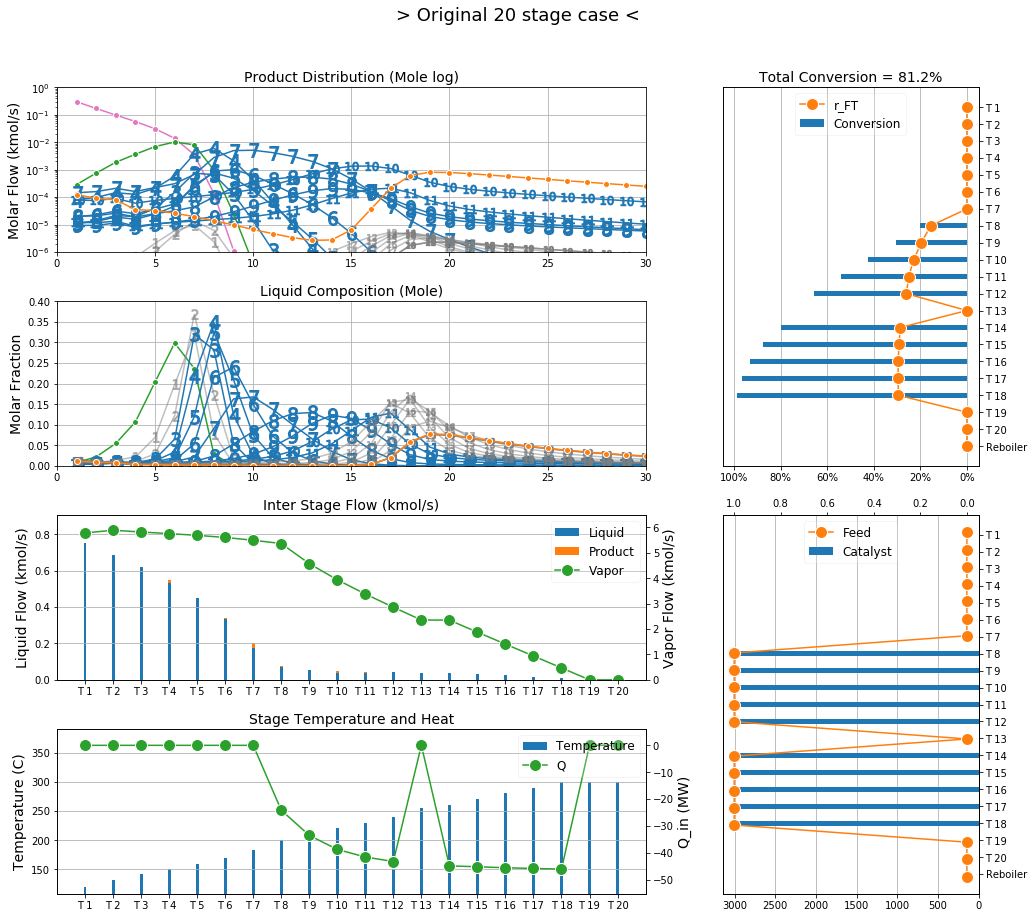

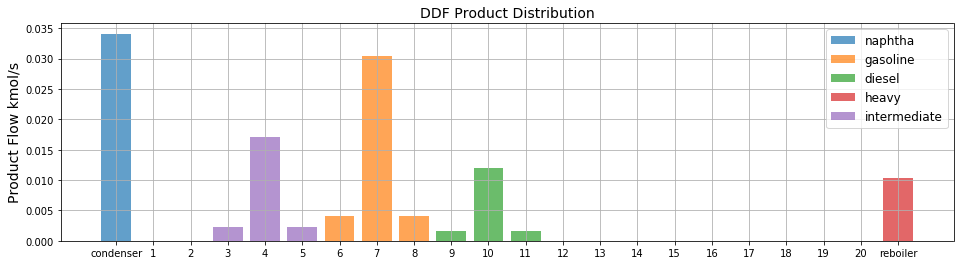

In [19]:
with HiddenLogs(log_text_dir,'w'):
    print('\n>','Original 20 stage case')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Original 20 stage case')
plot_product_distribution(model,pdf)

# Optimization

### Open up parameters

In [20]:
for j in model.TRAY_reactive:
    model.reactive[j].T.setlb(200+273.15)
    model.reactive[j].T.setub(300+273.15)
    
model.condenser.PR_L.unfix()
model.condenser.PR_L.setlb(0.05)
model.condenser.PR_L.setub(0.5)

model.P_total['intermediate'].unfix()
model.P_total['gasoline'].unfix()
model.P_total['diesel'].unfix()

### Constraints

In [21]:
model.quality_spec = pe.Param(m.PRODUCT,initialize={\
                    'naphtha':0.75,'gasoline':0.75,'diesel':0.6,'heavy':0.85},mutable=True)

def product_spec_rule(model,p):
    if p == 'intermediate':
        return pe.Constraint.Skip
    return sum(model.x_P_dry[i,p] for i in m.PRODUCT_cnumber[p]) >= model.quality_spec[p]
model.product_spec_con = pe.Constraint(m.PRODUCT,rule=product_spec_rule)

### Objective

In [22]:
model.del_component(model.obj)
model.obj = augmented_objective(pe,model,expr = model.P_total['gasoline'], sense = pe.maximize)

------------------------------------------------------------------------------------------------------------
> Obj = maximize
> P_total[gasoline]
------------------------------------------------------------------------------------------------------------


In [23]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -9.6999349e-02 3.27e+00 1.18e+02  -6.0 2.30e+03  -9.2 5.10e-01 1.20e-01h  1
  66 -9.8765242e-02 9.31e+00 1.02e+02  -6.0 3.50e+03  -9.7 2.27e-01 1.88e-01h  1
  67 -9.9553099e-02 9.14e+00 1.11e+02  -6.0 2.89e+03 -10.2 2.40e-01 7.94e-02h  1
  68 -1.0076356e-01 8.62e+00 9.55e+01  -6.0 1.30e+03  -9.7 9.82e-01 2.63e-01h  1
  69 -1.0140437e-01 7.33e+00 6.55e+01  -6.0 1.81e+03 -10.2 1.14e-01 3.02e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.0150185e-01 7.24e+00 7.26e+02  -6.0 1.48e+04 -10.7 5.70e-04 1.23e-02h  1
  71 -1.0183968e-01 4.82e+00 7.75e+02  -6.0 5.80e+02 -10.3 1.84e-02 3.52e-01h  1
  72 -1.0203775e-01 4.29e+00 6.92e+02  -6.0 1.17e+03 -10.7 3.27e-01 1.25e-01h  1
  73 -1.0205432e-01 4.17e+00 6.66e+02  -6.0 1.34e+04    -  2.14e-01 3.86e-02h  2
  74 -1.0243742e-01 3.54e+00 4.99e+02  -6.0 1.21e+03 -10.3 3.29e-01 2.48e-01h  1
  75 -1.0240409e-01 3.49e+00 4.10e+02  -6.0 1.38e+03    -  6.56e-03 1.77e-01h  1
  76 -1.0235414e-01 4.11e+00


> Optimized Temperature, Reflux and Product Side Draw
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 88.04%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -162.                                        2.1382          0.9921  0.0871       2.3287

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     133.7  0.000       0.000  0.000  0.000  0.000       5.5463  0.0000  1.2312  0.0000       20.000
NON--[2]     149.7  0.000       0.000  0.000  0.000  0.000       5.7854  0.0000  1.1758  0.0000       20.000
NON--[3]     160.9  0.000       0.000  0.000  0.000  0.000       5.7300  0.0000  1.1268  0.0000       20.000
NON--[4]     170.0  0.00

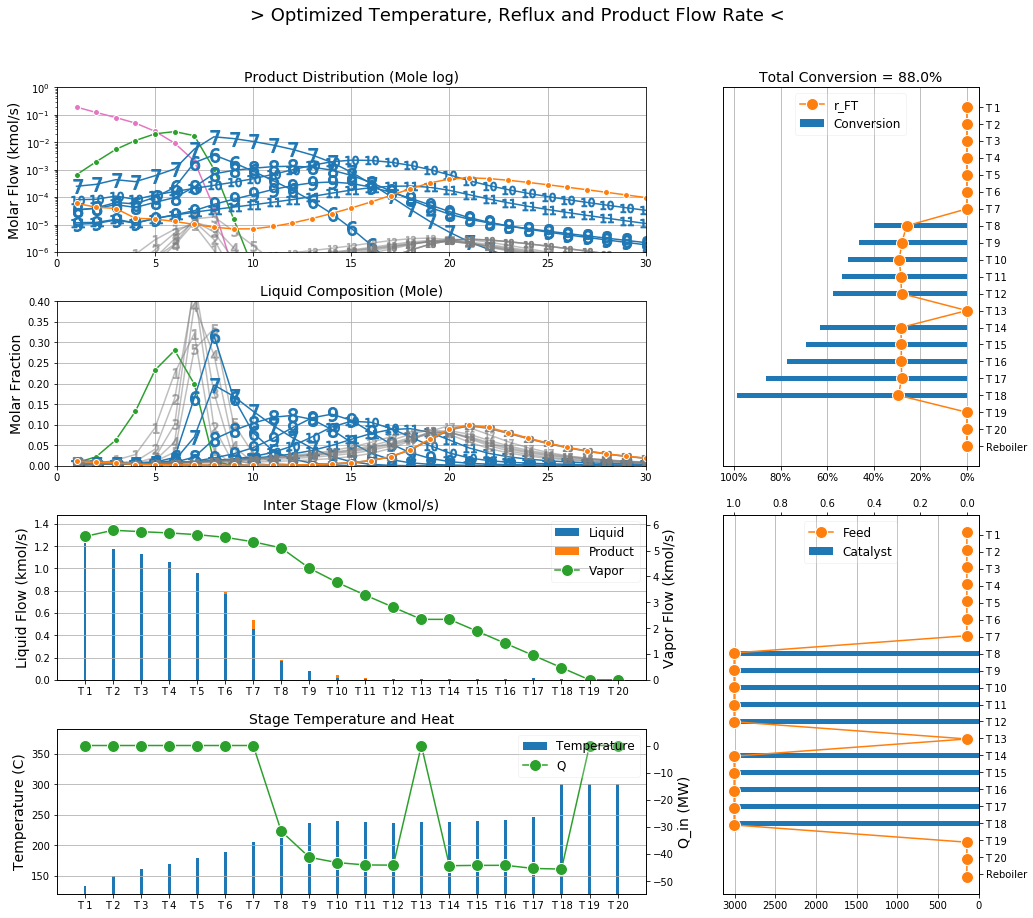

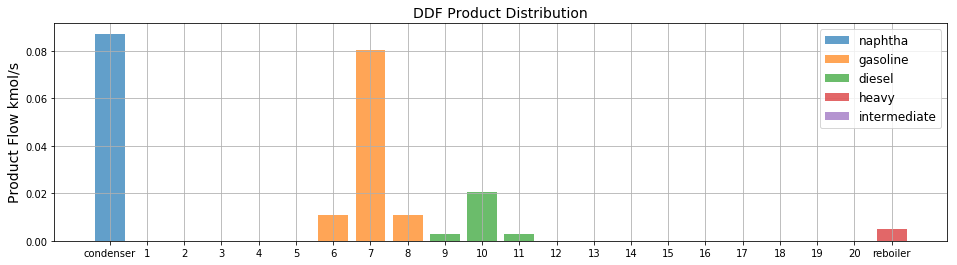

In [24]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Temperature, Reflux and Product Side Draw')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Temperature, Reflux and Product Flow Rate')
plot_product_distribution(model,pdf)

# Open up feed allocation

In [25]:
for j in model.reactive:
    model.reactive[j].F.unfix()
    model.reactive[j].F.setlb(0)
    model.reactive[j].F.setub(10)

In [26]:
model.total_feed_con = pe.ConstraintList()
model.total_feed_con.add(expr = sum(model.reactive[j].F for j in model.reactive) == 10);

In [27]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2092783e-01 4.11e+01 1.43e+03  -9.0 1.80e+03    -  6.78e-02 2.29e-01h  1
  66 -1.2092724e-01 4.11e+01 1.05e+04  -9.0 1.50e+03  -5.8 1.51e-05 4.43e-04h  1
  67 -1.2089308e-01 3.65e+01 9.27e+03  -9.0 7.76e+02    -  2.96e-05 1.15e-01h  1
  68 -1.2088896e-01 3.59e+01 9.10e+03  -9.0 2.85e+01  -6.3 2.22e-03 1.79e-02h  1
  69 -1.2085929e-01 3.16e+01 8.02e+03  -9.0 1.41e+01  -5.9 1.22e-02 1.19e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2083384e-01 2.80e+01 7.10e+03  -9.0 1.29e+01  -6.4 6.21e-02 1.15e-01h  1
  71 -1.2071235e-01 8.78e+00 2.23e+03  -9.0 1.64e+01  -6.8 2.51e-01 6.86e-01h  1
  72 -1.2069848e-01 2.93e+00 7.42e+02  -9.0 1.54e+01  -7.3 3.21e-01 6.67e-01h  1
  73 -1.2070447e-01 2.92e+00 7.40e+02  -9.0 2.37e+03    -  1.31e-01 2.69e-03h  1
  74 -1.2072314e-01 2.90e+00 7.34e+02  -9.0 1.73e+03    -  1.43e-02 8.30e-03h  1
  75 -1.2072999e-01 2.37e+00 6.01e+02  -9.0 2.67e+01  -7.8 6.91e-01 1.82e-01h  1
  76 -1.2074264e-01 2.36e+00


> Optimized Feed Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.50%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -149.                                        1.8411          0.6318  0.0962       2.4205

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
NON--[1]     125.4  0.000       0.000  0.000  0.000  0.000       4.9897  0.0000  0.7452  0.0000       20.000
NON--[2]     135.1  0.000       0.000  0.000  0.000  0.000       5.1031  0.0000  0.6909  0.0000       20.000
NON--[3]     142.8  0.000       0.000  0.000  0.000  0.000       5.0488  0.0000  0.6504  0.0000       20.000
NON--[4]     149.8  0.000       0.000  0.

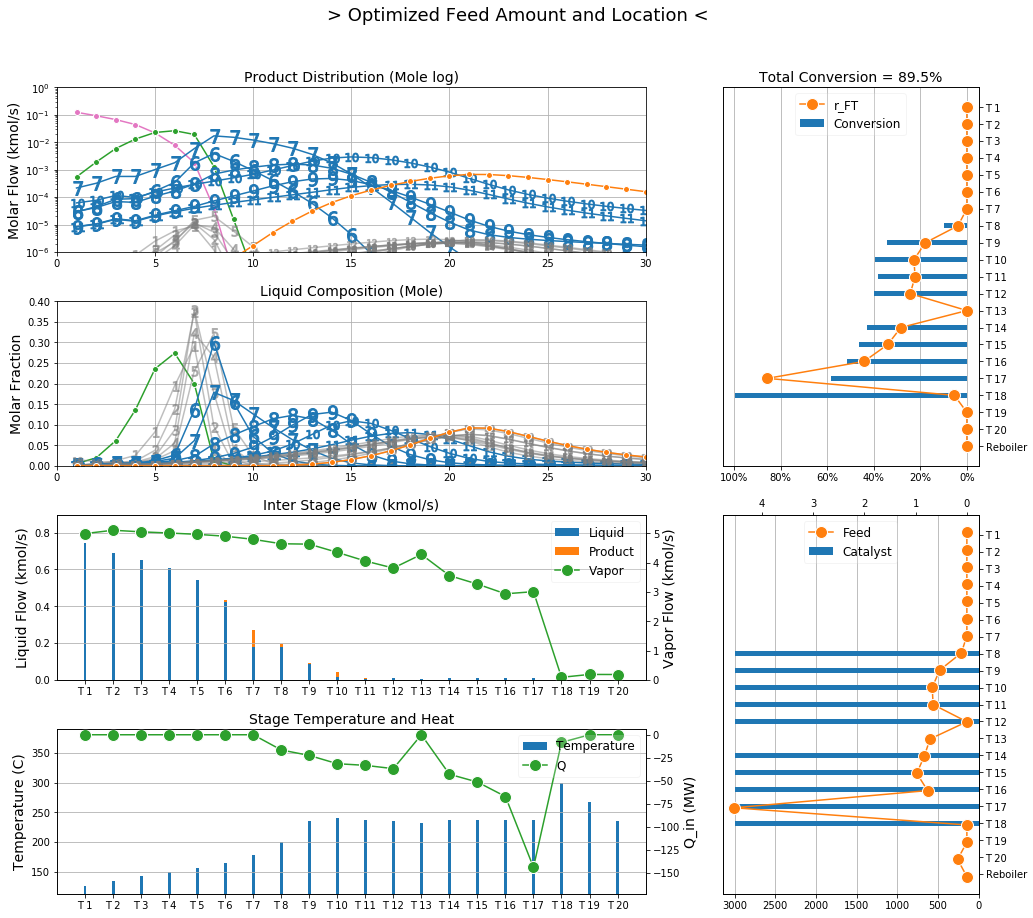

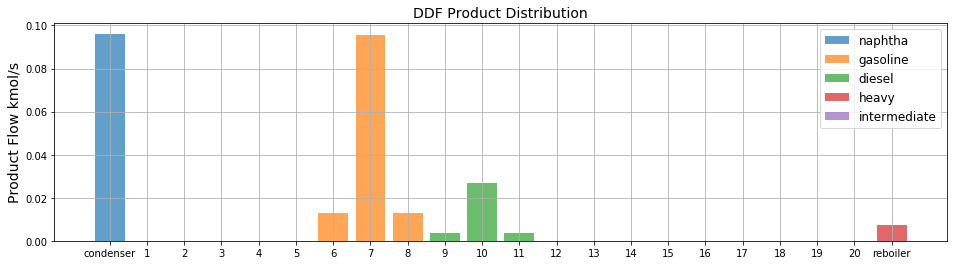

In [28]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Feed Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Feed Amount and Location')
plot_product_distribution(model,pdf)

# Open up catalyst allocation ( = TOTAL reconstruction, long wait time)

In [29]:
for j in model.reactive:
    model.reactive[j].cat.unfix()
    model.reactive[j].cat.setlb(10)
    model.reactive[j].cat.setub(30000)

In [30]:
model.total_cat_con = pe.ConstraintList()
model.total_cat_con.add(expr = sum(model.reactive[j].cat for j in model.reactive) == 10*3000);

In [31]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.1067785e-01 3.79e+00 1.11e+02  -6.0 4.59e+01  -1.1 4.98e-05 2.31e-04h  1
  66 -1.1067758e-01 3.79e+00 1.11e+02  -6.0 4.00e+01  -0.7 7.05e-05 2.97e-05h  1
  67 -1.1067109e-01 3.78e+00 1.08e+02  -6.0 1.27e+01  -0.3 3.21e-03 2.31e-03h  1
  68 -1.1068029e-01 3.78e+00 9.56e+01  -6.0 5.53e+01   0.2 5.82e-06 4.55e-04h  1
  69 -1.1068373e-01 3.78e+00 8.34e+01  -6.0 4.82e+01  -0.3 4.94e-06 3.60e-04f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.1069797e-01 3.77e+00 7.95e+01  -6.0 5.71e+01  -0.8 1.17e-04 8.29e-04f  1
  71 -1.1070239e-01 3.77e+00 7.91e+01  -6.0 5.89e+01  -1.3 2.71e-04 4.18e-04h  1
  72 -1.1071568e-01 3.77e+00 7.80e+01  -6.0 5.89e+01  -1.8 4.71e-03 1.27e-03h  1
  73 -1.1073984e-01 3.76e+00 7.77e+01  -6.0 5.79e+01  -2.2 5.10e-03 1.46e-03h  1
  74 -1.1082789e-01 3.73e+00 7.44e+01  -6.0 5.75e+01  -2.7 1.07e-02 7.26e-03h  1
  75 -1.1109428e-01 3.68e+00 9.46e+01  -6.0 5.71e+01  -3.2 1.10e-02 1.55e-02f  1
  76 -1.1122246e-01 3.64e+00

 156 -1.2689228e-01 1.59e+01 5.59e+04  -6.0 1.02e+03    -  4.66e-03 1.00e+00h  1
 157 -1.2688999e-01 1.00e+01 3.51e+04  -6.0 8.20e+01  -8.8 8.16e-01 3.73e-01h  1
 158 -1.2686842e-01 6.29e-01 2.21e+02  -6.0 1.92e+02  -9.3 1.00e+00 1.00e+00h  1
 159 -1.2690650e-01 6.70e+00 1.39e+02  -6.0 1.51e+03    -  6.85e-01 4.24e-01h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 160 -1.2689454e-01 4.75e+00 8.76e+01  -6.0 6.35e+02    -  1.00e+00 3.50e-01h  2
 161 -1.2687798e-01 2.83e+00 5.08e+01  -6.0 4.99e+02    -  1.00e+00 4.20e-01h  2
 162 -1.2687579e-01 1.58e+00 3.20e+01  -6.0 4.77e+02    -  1.00e+00 4.51e-01h  2
 163 -1.2686873e-01 1.83e+00 1.09e+02  -6.0 1.03e+03    -  1.00e+00 1.96e-01h  2
 164 -1.2685065e-01 3.01e+00 4.31e+01  -6.0 7.09e+02    -  1.00e+00 5.00e-01h  2
 165 -1.2685055e-01 3.11e+00 1.10e+02  -6.0 9.76e+02    -  8.90e-01 2.23e-01h  2
 166 -1.2683708e-01 3.89e+00 1.37e+02  -6.0 1.11e+03    -  1.00e+00 2.88e-01h  2
 167 -1.2683746e-01 5.56e+00

 249 -1.2920961e-01 6.33e-01 5.17e+00  -9.0 4.77e+03    -  3.78e-05 1.30e-04h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 250 -1.2920911e-01 6.33e-01 5.17e+00  -9.0 1.25e+04  -9.9 1.78e-04 4.54e-04h  6
 251 -1.2920972e-01 6.26e-01 5.11e+00  -9.0 3.84e+02  -9.5 9.64e-03 1.09e-02h  1
 252 -1.2920970e-01 6.26e-01 5.11e+00  -9.0 1.95e+04    -  5.86e-05 1.46e-04h  9
 253 -1.2920988e-01 6.26e-01 5.11e+00  -9.0 1.01e+04    -  2.60e-04 4.56e-04h  1
 254 -1.2921004e-01 6.05e-01 4.94e+00  -9.0 7.59e+01  -9.1 6.38e-02 3.44e-02f  1
 255 -1.2921305e-01 6.02e-01 4.92e+00  -9.0 1.07e+04    -  8.69e-03 4.21e-03h  1
 256 -1.2921357e-01 6.01e-01 4.91e+00  -9.0 4.01e+03    -  3.56e-01 1.78e-03h  1
 257 -1.2937946e-01 6.08e+01 1.87e+00  -9.0 3.00e+03    -  6.00e-02 6.19e-01f  1
 258 -1.2937783e-01 5.81e+01 1.78e+00  -9.0 8.93e+03    -  8.06e-04 4.83e-02h  1
 259 -1.2937732e-01 5.72e+01 1.75e+00  -9.0 2.48e+02  -9.6 1.60e-01 1.57e-02h  1
iter    objective    inf_pr 


> Optimized Catalyst Amount and Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 90.07%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -151.                                        1.7162          0.6139  0.0978       2.4736

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
React[1]     125.8  0.000       0.000  0.000  0.000  10.00       4.9017  0.0000  0.7251  0.0000       20.000
React[2]     135.2  0.000       0.000  0.000  0.000  10.00       5.0129  0.0000  0.6713  0.0000       20.000
React[3]     142.8  0.000       0.000  0.000  0.000  10.00       4.9591  0.0000  0.6315  0.0000       20.000
React[4]     149.7  0.000       0.000

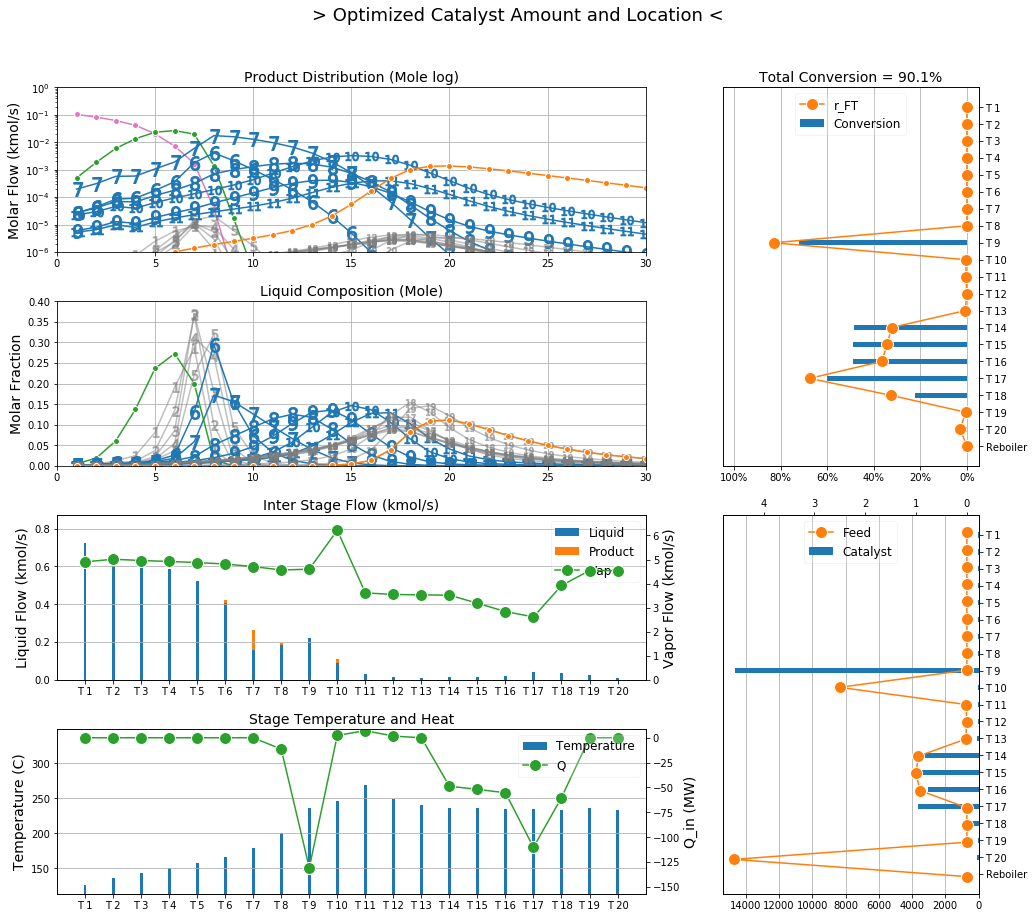

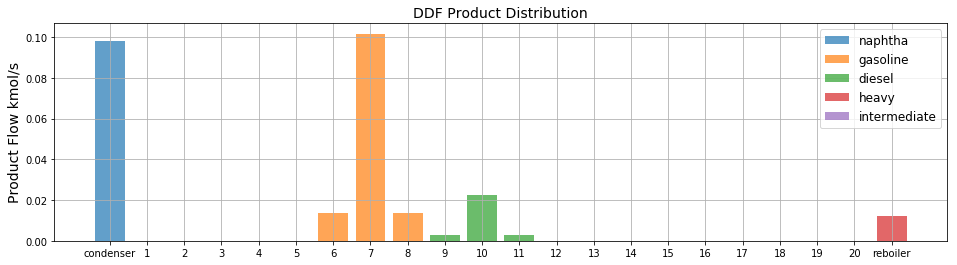

In [32]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Catalyst Amount and Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Catalyst Amount and Location')
plot_product_distribution(model,pdf)

# Use DDF,  open up gasoline location

In [33]:
model.N_tray['gasoline'].unfix();
model.N_tray['gasoline'].setlb(4)
model.N_tray['gasoline'].setub(10)

In [34]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.2913404e-01 2.99e-01 2.14e-02  -6.0 1.03e+02  -8.7 1.00e+00 1.00e+00h  1
  66 -1.2906251e-01 1.25e+00 3.64e-01  -6.0 2.02e+03  -9.2 9.72e-02 9.24e-02h  1
  67 -1.2903987e-01 3.10e-01 2.01e+00  -6.0 5.63e+02    -  1.00e+00 1.00e+00h  1
  68 -1.2907121e-01 1.14e+00 6.65e+01  -6.0 2.67e+02  -8.8 5.94e-01 7.50e-01h  1
  69 -1.2899786e-01 1.30e+00 1.64e+03  -6.0 4.09e+02    -  1.00e+00 6.98e-01h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.2919002e-01 9.28e-01 2.57e+03  -6.0 4.33e+02    -  3.55e-01 5.36e-01h  1
  71 -1.2879876e-01 7.10e-01 5.38e+04  -6.0 1.86e+02    -  5.48e-02 9.08e-01h  1
  72 -1.2875527e-01 1.34e+00 1.97e+01  -6.0 3.36e+02    -  7.81e-01 1.00e+00H  1
  73 -1.2881697e-01 1.49e-01 1.14e+01  -6.0 1.14e+02    -  4.94e-01 1.00e+00h  1
  74 -1.2880497e-01 4.68e-04 1.55e-03  -6.0 5.86e+00    -  1.00e+00 1.00e+00h  1
  75 -1.2880520e-01 5.44e-06 1.12e-05  -6.0 1.01e+00    -  1.00e+00 1.00e+00h  1
  76 -1.2880520e-01 1.52e-10


> Optimized Gasoline Location
------------------------------------------------------------------------------------------------------------
Here comes the result:
Total Conversion: 89.94%
------------------------------------------------------------------------------------------------------------
stages       T      Q                                            V               L       P            W     
condenser    30.00  -148.                                        1.7315          0.5600  0.0915       2.4631

stages       T      Q           r_FT   Conv%  F      cat         V       Re      L       P            P_VLE 
React[1]     123.2  0.000       0.000  0.000  0.000  10.00       4.8462  0.0000  0.6494  0.0000       20.000
React[2]     131.7  0.000       0.000  0.000  0.000  10.00       4.9356  0.0000  0.5913  0.0000       20.000
React[3]     139.5  0.000       0.000  0.000  0.000  10.00       4.8776  0.0000  0.5421  0.0000       20.000
React[4]     147.5  0.000       0.000  0.000  0.

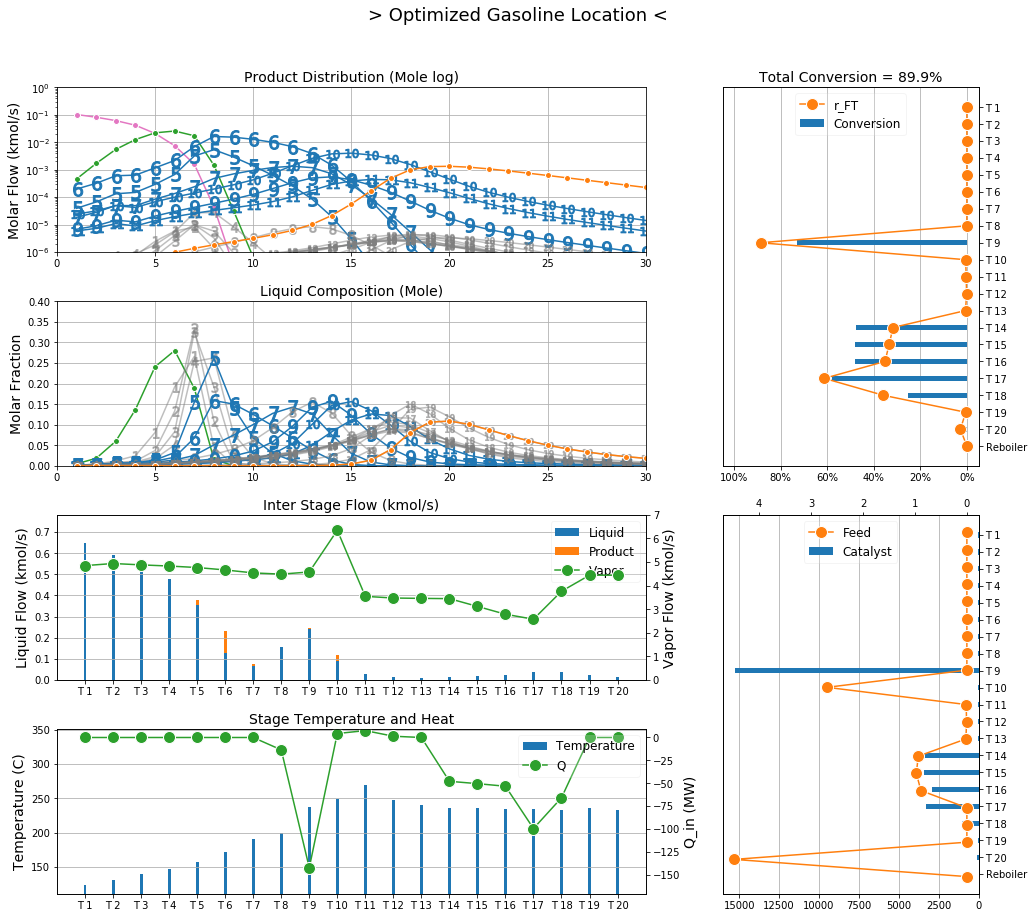

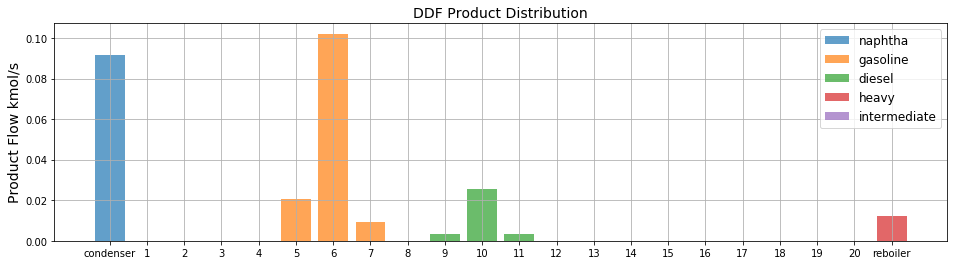

In [35]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Gasoline Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Gasoline Location')
plot_product_distribution(model,pdf)

In [36]:
model.N_tray['diesel'].unfix();
model.N_tray['diesel'].setlb(5)
model.N_tray['diesel'].setub(20)

In [ ]:
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.12.10: print_user_options=yes
linear_solver=ma86
linear_system_scaling=mc19
max_iter=500
warm_start_init_point=yes
warm_start_bound_push=1e-20
warm_start_mult_bound_push=1e-20
mu_init=1e-06
output_file=./tmp/ipopt_output_tmp.output
linear_scaling_on_demand=no
required_infeasibility_reduction=0.999999999999999


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                    yes
                           linear_solver = ma86                  yes
                   linear_system_scaling = mc19                  yes
                                max_iter = 500                   yes
                                 mu_init = 1e-06                 yes
                             output_file = ./tmp/ipopt_output_tmp.output  yes
                      print_user_options = yes                   yes
        required_infeasibility_reduction = 1                      no
                   war

  65 -1.3058670e-01 4.03e-03 3.65e-02  -6.0 1.94e+01  -9.1 1.00e+00 1.00e+00h  1
  66 -1.3058252e-01 3.88e-04 4.22e-03  -6.0 9.95e+00  -9.6 1.00e+00 1.00e+00h  1
  67 -1.3058305e-01 3.85e-03 1.46e-03  -6.0 1.50e+01 -10.1 1.00e+00 1.00e+00h  1
  68 -1.3058360e-01 2.91e-01 1.22e+00  -6.0 1.61e+02 -10.5 1.00e+00 5.00e-01h  2
  69 -1.3058375e-01 5.42e-02 1.50e-04  -6.0 1.81e+01  -9.2 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -1.3058409e-01 6.41e-02 7.79e-04  -6.0 4.11e+01  -9.7 1.00e+00 1.00e+00h  1
  71 -1.3058451e-01 1.30e-01 1.61e-02  -6.0 4.96e+01    -  1.00e+00 1.00e+00h  1
  72 -1.3058445e-01 2.01e-03 1.97e-05  -6.0 6.62e+00    -  1.00e+00 1.00e+00h  1
  73 -1.3058445e-01 4.58e-07 4.50e-09  -6.0 9.62e-02    -  1.00e+00 1.00e+00h  1
  74 -1.3145698e-01 8.91e-01 1.30e+01  -9.0 2.17e+03    -  1.43e-01 1.78e-01f  1
  75 -1.3165136e-01 9.92e-01 3.00e+01  -9.0 1.95e+03    -  2.81e-01 6.55e-02h  1
  76 -1.3218835e-01 5.62e+00

In [ ]:
with HiddenLogs(log_text_dir):
    print('\n>','Optimized Diesel Location')
    print('-'*108)
    beautify(pe,model)
    check_product_spec(model)
    log_now()
    check_iteration()

plot_distribution(model,pdf,'Optimized Diesel Location')
plot_product_distribution(model,pdf)

In [ ]:
pdf.close()

In [ ]:
# with open('./log/model/{}.pickle'.format(logname),'wb') as f:
#     dill.dump(model,f)